In [1]:
import os
os.environ["CACHE_DIR"] = "/ihome/djishnu/alw399/.cache"

In [4]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
# from anndata import AnnData
# import pathlib
import matplotlib.pyplot as plt
# import matplotlib as mpl
# import skimage
import seaborn as sns
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored


scanpy==1.10.2 anndata==0.10.8 umap==0.5.3 numpy==1.26.0 scipy==1.12.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.4 igraph==0.11.6 louvain==0.8.1 pynndescent==0.5.10
squidpy==1.6.1


In [5]:
# adata = sc.read_10x_mtx('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/mouse_kidney_visiumHD/square_008um/filtered_feature_bc_matrix')
# spatial = pd.read_parquet('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/mouse_kidney_visiumHD/square_008um/spatial/tissue_positions.parquet')
adata = sc.read_10x_mtx('/ix/djishnu/alw399/SpaceOracle/data/mouse_kidney_visiumHD/binned_outputs/square_008um/filtered_feature_bc_matrix')
spatial = pd.read_parquet('/ix/djishnu/alw399/SpaceOracle/data/mouse_kidney_visiumHD/binned_outputs/square_008um/spatial/tissue_positions.parquet')

barcodes = list(set(adata.obs_names) & set(spatial['barcode'].values))
adata = adata[barcodes, :]

spatial.set_index('barcode', inplace=True)
adata.obs = spatial.loc[barcodes]
adata.obsm['spatial'] = spatial[['pxl_row_in_fullres', 'pxl_col_in_fullres']].loc[barcodes].values
adata_st = adata 
adata_st

AnnData object with n_obs × n_vars = 502009 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [6]:
min_counts = 100

adata_st.var["MT"] =adata_st.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_st, qc_vars=["MT"], inplace=True)
sc.pp.filter_cells(adata_st, min_counts=min_counts)
adata_st= adata_st[adata_st.obs["pct_counts_MT"] < 20].copy()
adata_st.shape

(415538, 19059)

In [7]:
# adata_sc = sc.read_h5ad('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/mouse_kidney_survey/mouse_kidney_13.h5ad')
adata_sc = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
# adata_sc.obs['cluster'] = adata_sc.obs['ct1']
adata_sc

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [8]:
celltypes = adata_sc.obs['ct3'].unique()

# ct3 is finer resolution than cell_types, which CO GRN and COMMOT LRs use

mapping = {}
for ct3 in celltypes:
    value = adata_sc[adata_sc.obs['ct3'] == ct3].obs['cell_type'].drop_duplicates().iloc[0]
    mapping[ct3] = value

adata_sc.obs['cell_type'].value_counts()

cell_type
Myeloid                5266
Endothelial            1779
Epithelial              462
B                       442
T                       361
Mesenchymal_Stromal     128
NK                       71
Name: count, dtype: int64

In [ ]:
# sc.tl.pca(adata_sc)
# sc.pp.neighbors(adata_sc)
# sc.tl.umap(adata_sc)

ReferenceError: underlying object has vanished

In [3]:
import decoupler as dc

markers = dc.get_resource(
    name='PanglaoDB',
    organism='mouse',
    license='academic'
)
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['mouse_sensitivity'].astype(float) > 0.5)]
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers = markers[markers['organ'] == 'Kidney']
markers

/ix3/djishnu/alw399/envs/sheep/lib/python3.9/site-packages/liana/resource/_orthology.py:199: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


,genesymbol,_entity_type,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
92,Acta2,protein,False,Juxtaglomerular cells,Mesoderm,True,0.0,0.0194236,True,1.0,0.0386985,9606,Kidney,0.035
159,Adgrf5,protein,True,Intercalated cells,Mesoderm,True,0.0,0.0178571,True,0.555556,0.0540245,9606,Kidney,0.047
162,Adgrg1,protein,False,Principal cells,Mesoderm,True,0.0,0.0213033,True,1.0,0.0499422,9606,Kidney,0.045
363,Apela,protein,False,Principal cells,Mesoderm,True,0.0,0.00219298,True,1.0,0.00423674,9606,Kidney,0.004
408,Aqp2,protein,True,Principal cells,Mesoderm,True,0.0,0.000626566,True,1.0,0.000320965,9606,Kidney,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4944,Pck1,protein,True,Proximal tubule cells,Mesoderm,True,1.0,0.0153557,True,0.9,0.0034805,9606,Kidney,0.008
5044,Pdzk1ip1,protein,False,Principal cells,Mesoderm,True,0.0,0.0432331,True,1.0,0.0227885,9606,Kidney,0.025
5077,Pgam2,protein,True,Distal tubule cells,Mesoderm,True,0.0,0.0,True,0.531915,0.0135796,9606,Kidney,0.012
5244,Podxl,protein,True,Podocytes,Mesoderm,True,1.0,0.0343849,True,0.944444,0.0387358,9606,Kidney,0.04


In [9]:
tg.pp_adatas(adata_sc, adata_st, genes=markers['genesymbol'].values)

44 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
2978 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [ ]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="cells",
    # mode="clusters",
    # cluster_label='cell_type',  # .obs field w cell types
    cluster_label='ct3',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
    # device="cuda:0",
    device='cpu',
    # device='mps'
)

ad_map.write('/ix/djishnu/shared/djishnu_kor11/tangram_outputs/mouse_kidney_13-mouse_kidney_visium.h5ad')

In [ ]:
ad_map

In [ ]:
adata_st

AnnData object with n_obs × n_vars = 415538 × 18999
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'uniform_density', 'rna_count_based_density'
    var: 'gene_ids', 'feature_types', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'sparsity'
    uns: 'training_genes', 'overlap_genes'
    obsm: 'spatial'

In [ ]:
# tg.project_cell_annotations(ad_map, adata_st, annotation="cell_type")
tg.project_cell_annotations(ad_map, adata_st, annotation="ct3")


spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


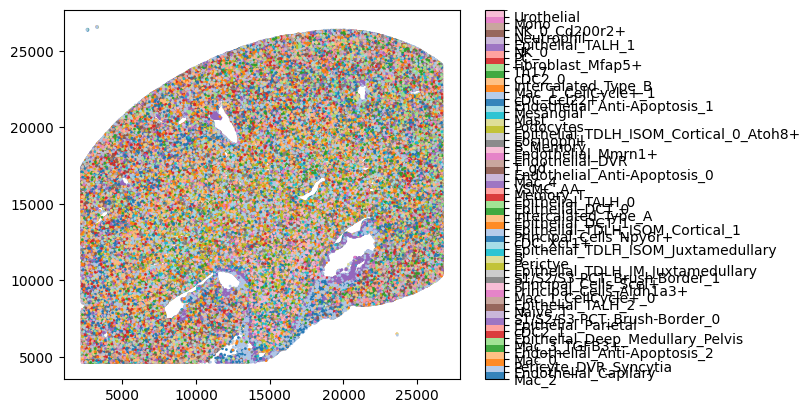

In [ ]:
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
unique_cell_types = adata_st.obs['predicted'].unique()
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

# Create a numeric representation of the predicted cell types
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['predicted'].map(cell_type_to_numeric)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
cmap = ListedColormap(sns.color_palette("tab20", len(unique_cell_types)).as_hex())
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

# Plot the scatter plot
plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

# Create a color bar with cell type labels
cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types)

plt.show()


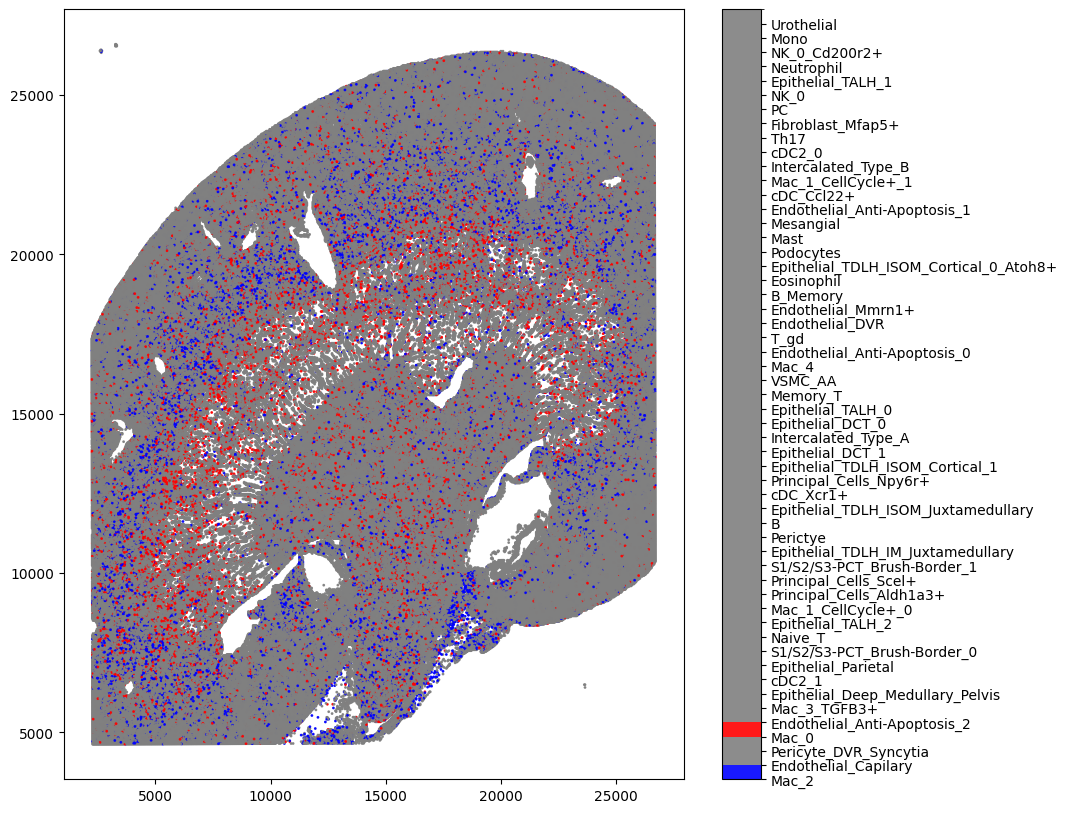

In [ ]:
plt.figure(figsize=(10, 10))
unique_cell_types = adata_st.obs['predicted'].unique()
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['predicted'].map(cell_type_to_numeric)

colors = ['gray'] * len(unique_cell_types)
if 'Mac_0' in cell_type_to_numeric:
    colors[cell_type_to_numeric['Mac_0']] = 'red'
if 'Mac_2' in cell_type_to_numeric:
    colors[cell_type_to_numeric['Mac_2']] = 'blue'
cmap = ListedColormap(colors)
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types)

plt.show()


In [ ]:
adata_st.obs['predicted'].value_counts()

predicted
Mac_2                                     26785
Mac_0                                     24003
Endothelial_Capilary                      22554
Epithelial_TDLH_ISOM_Juxtamedullary       14502
Principal_Cells_Aldh1a3+                  13626
Epithelial_TDLH_IM_Juxtamedullary         12896
Principal_Cells_Npy6r+                    12826
Epithelial_TDLH_ISOM_Cortical_0_Atoh8+    12694
Principal_Cells_Scel+                     12546
Epithelial_TDLH_ISOM_Cortical_1           12524
Pericyte_DVR_Syncytia                     12454
Epithelial_Parietal                       12262
Endothelial_Anti-Apoptosis_0              11521
Epithelial_TALH_0                         11467
Mac_3_TGFB3+                              11191
S1/S2/S3-PCT_Brush-Border_1               10339
Endothelial_Anti-Apoptosis_2               9285
Epithelial_Deep_Medullary_Pelvis           9169
VSMC_AA                                    8768
Mesangial                                  8382
Endothelial_DVR               

In [ ]:
adata_st.obs['predicted'].to_csv('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/mouse_kidney_visiumHD/tangram_annotations.csv')

In [ ]:
ad_ge = tg.project_genes(
                  ad_map, 
                  adata_sc,
                  cluster_label='ct3')

del(adata_sc) # make space because running locally
del(adata)
import gc
gc.collect()

13523

In [ ]:
ad_ge

AnnData object with n_obs × n_vars = 415538 × 3058
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'is_training'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap', 'training_genes', 'overlap_genes'

In [ ]:
ad_ge.layers['raw_count'] = adata_st.to_df().reindex(ad_ge.var_names, axis=1).fillna(0)
ad_ge

AnnData object with n_obs × n_vars = 415538 × 3058
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'uniform_density', 'rna_count_based_density'
    var: 'n_cells', 'is_training'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap', 'training_genes', 'overlap_genes'
    layers: 'raw_count'

In [ ]:
ad_ge.layers['imputed_count'] = ad_ge.X.copy()

# Put X back as raw count 
ad_ge.X = ad_ge.layers['raw_count'].copy()

In [ ]:
ad_ge.obs['predicted'] = adata_st.obs['predicted']

# relabel so I don't have to rename all the variables in the future cells
adata_st = ad_ge
gc.collect()

0

In [ ]:

# sc.pp.normalize_total(adata, target_sum=1e4) # not sure that every spot should contain same amount
sc.pp.log1p(adata_st)
adata_st.layers['normalized_count'] = adata_st.X.copy()

In [ ]:
adata_st.var_names = adata_st.var_names.str.capitalize()
adata_st

AnnData object with n_obs × n_vars = 415538 × 3058
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'uniform_density', 'rna_count_based_density', 'predicted'
    var: 'n_cells', 'is_training'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap', 'training_genes', 'overlap_genes', 'log1p'
    layers: 'raw_count', 'imputed_count', 'normalized_count'

In [ ]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.utils import clean_up_adata
from spaceoracle.tools.network import encode_labels


In [ ]:
adata_st.obsm['spatial'] = spatial[['pxl_row_in_fullres', 'pxl_col_in_fullres']].loc[adata_st.obs_names].values

In [ ]:
from spaceoracle.tools.utils import scale_adata

adata_st = scale_adata(adata_st, cell_size=8)
adata_st

AnnData object with n_obs × n_vars = 415538 × 3058
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'uniform_density', 'rna_count_based_density', 'predicted'
    var: 'n_cells', 'is_training'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap', 'training_genes', 'overlap_genes', 'log1p'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'raw_count', 'imputed_count', 'normalized_count'

In [ ]:
adata_st.obs['ct3'] = adata_st.obs['predicted']
adata_st.obs['cell_type'] = adata_st.obs['ct3'].map(mapping)
adata_st.obs['cell_type'].value_counts()

cell_type
Epithelial             172436
Myeloid                110483
Endothelial             58646
Mesenchymal_Stromal     36675
T                       20142
B                       13159
NK                       3997
Name: count, dtype: int64

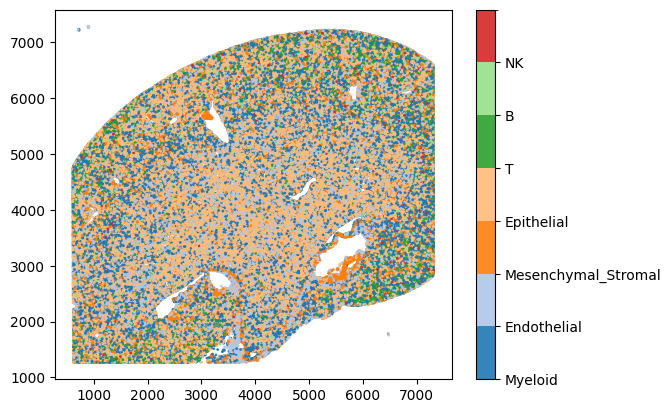

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
unique_cell_types = adata_st.obs['cell_type'].unique()

# Create a numeric representation of the predicted cell types
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['cell_type'].map(cell_type_to_numeric)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
cmap = ListedColormap(sns.color_palette("tab20", len(unique_cell_types)).as_hex())
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

# Plot the scatter plot
plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

# Create a color bar with cell type labels
cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types)

plt.show()


In [ ]:
adata_st.obs['cell_type'] = adata_st.obs['cell_type'].astype('category')
adata_st.obs['cell_type_int'] = adata_st.obs['cell_type'].apply(
    lambda x: encode_labels(adata_st.obs['cell_type'], reverse_dict=True)[x])


In [ ]:
clean_up_adata(adata_st, ['cell_type', 'cell_type_int', 'spatial', 'ct3'])
adata_st


AnnData object with n_obs × n_vars = 415538 × 3058
    obs: 'ct3', 'cell_type', 'cell_type_int'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'raw_count', 'imputed_count', 'normalized_count'

In [ ]:
adata_st.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_visium.h5ad')